# PyTorch 3DCNN Classfication (Subject Base data Splitting)
This notebook using PyTorch and cudaGPU.

In [17]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"decive: {device}")

decive: cuda


# 讀取數據

In [19]:
csv_path = 'structured_data_mac.csv'
df = pd.read_csv(csv_path)

# 檢查並清理數據

In [20]:
if df['Group'].isnull().any():
    df = df.dropna(subset=['Group'])

# 檢查是否存在非預期的標籤值

In [21]:
expected_labels = ['CN', 'MCI', 'AD']
df = df[df['Group'].isin(expected_labels)]

image_paths = df['Image Path'].tolist()

# 將標籤映射為數字

In [22]:
label_mapping = {'CN': 0, 'MCI': 1, 'AD': 2}
labels = df['Group'].map(label_mapping).tolist()

# 獲取個別的病人ID

In [23]:
unique_patients = df['Subject'].unique()

# 根據病人ID進行訓練和驗證分割

In [24]:
train_ids, val_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)

# 創建訓練和驗證DataFrame

In [25]:
train_df = df[df['Subject'].isin(train_ids)]
val_df = df[df['Subject'].isin(val_ids)]

# 提取訓練和驗證影像路徑和標籤

In [26]:
train_paths = train_df['Image Path'].tolist()
train_labels = train_df['Group'].map(label_mapping).tolist()
val_paths = val_df['Image Path'].tolist()
val_labels = val_df['Group'].map(label_mapping).tolist()

# 將標籤轉換為 tensor

In [27]:
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

In [28]:
# Define the PyTorch dataset class
class NiftiDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        nifti_path = self.image_paths[idx]
        label = self.labels[idx]
        nifti_image = nib.load(nifti_path)
        image = nifti_image.get_fdata()
        image = np.resize(image, (96, 96, 96))
        image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0)  # Add channel dimension
        return image, label

In [29]:
# Create dataset instances
train_dataset = NiftiDataset(train_paths, train_labels_tensor)
val_dataset = NiftiDataset(val_paths, val_labels_tensor)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 3D CNN 模型架構定義
## 模型組件

1. **卷積層（Convolutional Layers）**：
    - 第一層：使用16個3x3x3的過濾器。
    - 第二層：使用32個3x3x3的過濾器。

2. **池化層（Pooling Layers）**：
    - 每個卷積層後面跟著的最大池化層，使用2x2x2的池化窗口。

3. **批量歸一化層（Batch Normalization Layers）**：
    - 在每個池化層之後進行批量歸一化，有助於模型學習過程中的穩定性和效率。

4. **全局平均池化層（Global Average Pooling Layer）**：
    - 對特徵圖進行全局平均池化，將每個特徵通道的空間維度縮減為單一數值。

5. **全連接層（Dense Layers）**：
    - 第一層：32個輸入特徵映射到64個神經元。
    - Dropout層：在全連接層後添加，dropout比例設為0.3，以減少訓練過程中的過擬合。

6. **輸出層（Output Layer）**：
    - 將64個神經元的輸出映射到3個輸出單元，對應於3個不同類別的預測。

In [30]:
class Conv3DNet(nn.Module):
    def __init__(self, width, height, depth):
        super(Conv3DNet, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3)
        self.pool1 = nn.MaxPool3d(kernel_size=2)  # Corrected keyword argument here
        self.bn1 = nn.BatchNorm3d(num_features=16)
        self.dropout1 = nn.Dropout(0.3)

        # Convolutional Layer 2
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3)
        self.pool2 = nn.MaxPool3d(kernel_size=2)  # Corrected keyword argument here
        self.bn2 = nn.BatchNorm3d(num_features=32)
        self.dropout1 = nn.Dropout(0.3)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)

        # Dense Layer
        self.fc1 = nn.Linear(in_features=32, out_features=64)
        self.dropout = nn.Dropout(0.3)

        # Output Layer
        self.fc2 = nn.Linear(in_features=64, out_features=3)

    def forward(self, x):
        # Apply first convolutional block
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.bn1(x)

        # Apply second convolutional block
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.bn2(x)

        # Apply global average pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor

        # Apply dense layer with dropout
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)
        return nn.Softmax(dim=1)(x)

In [31]:
model = Conv3DNet(96, 96, 96).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練與驗證 3D CNN 模型

此代碼塊主要用於訓練和驗證一個三維卷積神經網路（3D CNN）模型。模型被訓練來處理醫學影像數據，並在20個週期（epochs）內進行迭代訓練和驗證。

## 訓練過程

- 每個週期開始時，模型設定為訓練模式。
- 數據被加載並分批（通過 `train_loader`）傳遞到模型中。
- 對於每一批數據，模型首先在GPU上進行計算（`.to('cuda')`），然後進行前向傳播，計算損失，並進行反向傳播更新模型參數。
- 訓練損失被累加，用於後續計算整個週期的平均訓練損失。
- 同時，模型預測和真實目標被收集，用於計算訓練準確度和F1分數。

## 驗證過程

- 在每個訓練週期後，模型切換到評估模式。
- 使用不參與訓練的驗證數據集（通過 `val_loader` 加載）來評估模型的性能。
- 在這個階段，不進行梯度計算（`torch.no_grad()`），以減少內存使用並加速處理。
- 驗證損失、驗證準確度和驗證F1分數被計算，以評估模型在未見數據上的表現。

## 保存模型和早期停止

- 如果在某個週期的驗證損失比之前所有週期都低，或者驗證準確度有提高，則保存該模型。
- 兩種不同的保存策略：一種基於最低驗證損失（`Subject_based_Splitting_3DCNN_pytorch_model_min_loss.pth`），另一種基於最高驗證準確度（`Subject_based_Splitting_3DCNN_pytorch_model_max_accuracy.pth`）。
- 如果連續多個週期沒有改善（在這個例子中是超過3個週期），則實行早期停止，以防止過擬合。

## 性能輸出

- 每個週期結束時，打印訓練和驗證損失，以及準確度和F1分數，以便於追蹤模型的學習進度和性能。



Validation Epoch 1/20: 100%|██████████| 11/11 [00:56<00:00,  5.16s/it]


Epoch 1, Train Loss: 1.0839006543159484, Validation Loss: 1.009387043389407
Training Accuracy: 0.4309327036599764, Training F1: 0.4242668705036399
Validation Accuracy: 0.6314152410575428, Validation F1: 0.48875993874044293


Validation Epoch 2/20: 100%|██████████| 11/11 [00:45<00:00,  4.10s/it]


Epoch 2, Train Loss: 1.0470580816268922, Validation Loss: 0.9294103709134188
Training Accuracy: 0.5112160566706021, Training F1: 0.3638450143315907
Validation Accuracy: 0.6314152410575428, Validation F1: 0.48875993874044293


Validation Epoch 3/20: 100%|██████████| 11/11 [00:59<00:00,  5.45s/it]


Epoch 3, Train Loss: 1.0273439109325408, Validation Loss: 1.016812335361134
Training Accuracy: 0.5049193231011413, Training F1: 0.3448686535699527
Validation Accuracy: 0.48055987558320373, Validation F1: 0.4627314867969518


Validation Epoch 4/20: 100%|██████████| 11/11 [00:44<00:00,  4.03s/it]


Epoch 4, Train Loss: 1.0154163062572479, Validation Loss: 0.8987211964347146
Training Accuracy: 0.521448248720976, Training F1: 0.3992475972049639
Validation Accuracy: 0.6205287713841369, Validation F1: 0.48355984871777263


Validation Epoch 5/20: 100%|██████████| 11/11 [00:55<00:00,  5.03s/it]


Epoch 5, Train Loss: 1.0031537145376206, Validation Loss: 1.1174036156047473
Training Accuracy: 0.5356158992522629, Training F1: 0.45431928496958884
Validation Accuracy: 0.28771384136858474, Validation F1: 0.20755654175098856


Validation Epoch 6/20: 100%|██████████| 11/11 [00:57<00:00,  5.24s/it]


Epoch 6, Train Loss: 0.996987746655941, Validation Loss: 1.099396358836781
Training Accuracy: 0.5415190869736324, Training F1: 0.46153841816256325
Validation Accuracy: 0.3328149300155521, Validation F1: 0.27613744599199386
Stopping early due to no improvement in validation loss.


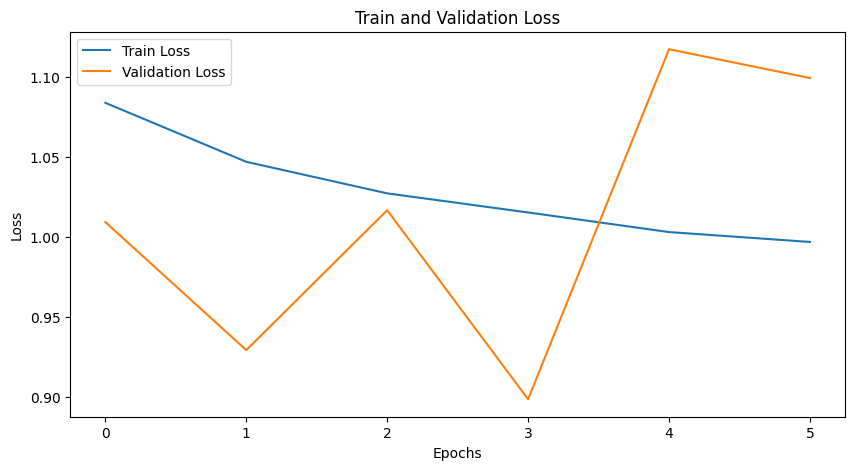

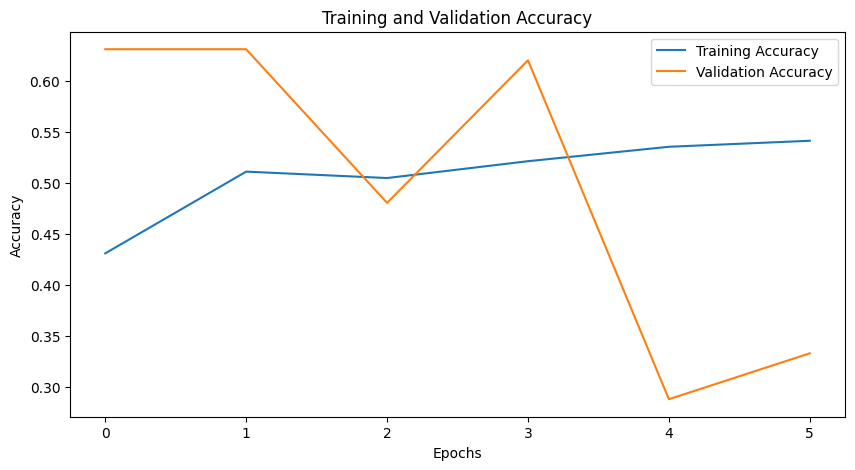

In [32]:
epochs = 20
best_val_loss = float('inf')
patience = 0
best_val_accuracy = 0.0

# 初始化用於繪圖的列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # 訓練階段
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []
    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        images = images.to('cuda')
        targets = targets.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # 收集預測和目標
        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_targets.extend(targets.cpu().numpy())

    # 驗證階段
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            images = images.to('cuda')
            targets = targets.to('cuda')
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, targets)
            val_loss += loss.item()

            # 收集預測和目標
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_targets.extend(targets.cpu().numpy())

    # 計算準確度和 F1 分數
    train_accuracy = accuracy_score(all_train_targets, all_train_preds)
    train_f1 = f1_score(all_train_targets, all_train_preds, average='weighted')
    val_accuracy = accuracy_score(all_val_targets, all_val_preds)
    val_f1 = f1_score(all_val_targets, all_val_preds, average='weighted')

    # 計算並儲存每次迭代的損失和準確率
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")
    print(f"Training Accuracy: {train_accuracy}, Training F1: {train_f1}")
    print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}")

    # 保存模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Subject_based_Splitting_3DCNN_pytorch_model_min_loss.pth')
        patience = 0
    else:
        patience += 1

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'Subject_based_Splitting_3DCNN_pytorch_model_max_accuracy.pth')
        patience = 0
    else:
        patience += 1

    # 早期停止
    if patience > 3:
        print("Stopping early due to no improvement in validation loss.")
        break

# 繪製損失圖
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製準確率圖
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 用dataB當作測試資料，測試用MRI預測GROUP的準確定

In [33]:
csv_path = 'dataB_change.csv'
df = pd.read_csv(csv_path)
df['image_path'] = df['Image Data ID'].apply(lambda x: f'dataB/{x}.nii')

In [34]:
if df['Group'].isnull().any():
    df = df.dropna(subset=['Group'])

In [35]:
df['Group'] = df['Group'].replace({'EMCI': 'MCI', 'LMCI': 'MCI', 'SMC': 'CN'})

expected_labels = ['CN', 'MCI', 'AD']
df = df[df['Group'].isin(expected_labels)]

image_paths = df['image_path'].tolist()

In [36]:
label_mapping = {'CN': 0, 'MCI': 1, 'AD': 2}
labels = df['Group'].map(label_mapping).tolist()

In [37]:
model = Conv3DNet(96, 96, 96) 
model.load_state_dict(torch.load('Subject_based_Splitting_3DCNN_pytorch_model_max_accuracy.pth'))
model.eval()

Conv3DNet(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool3d(output_size=1)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [38]:
def process_mri_image(image_path):

    nifti_image = nib.load(image_path)
    image = nifti_image.get_fdata()

    image = np.resize(image, (96, 96, 96))

    image = torch.tensor(image, dtype=torch.float32)

    image = image.unsqueeze(0) 

    return image

In [39]:
def predict_group(image_path, model):
    processed_image = process_mri_image(image_path)
    processed_image = torch.tensor(processed_image).unsqueeze(0)  
    with torch.no_grad():  
        output = model(processed_image)
    return output.argmax(dim=1)  


In [40]:
predictions = [predict_group(path, model) for path in image_paths]
predicted_labels = [list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in predictions]

C:\Users\MR600\AppData\Local\Temp\ipykernel_18456\1523513027.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(processed_image).unsqueeze(0)


# 得知模型對於dataB的準確度

In [41]:
results_df = pd.DataFrame({
    'Actual Label': df['Group'], 
    'Predicted Label': predicted_labels,
    'Image Path': image_paths
})

print(results_df)

     Actual Label Predicted Label         Image Path
0             MCI             MCI  dataB/I294134.nii
1             MCI             MCI  dataB/I294136.nii
2             MCI             MCI  dataB/I294138.nii
3             MCI             MCI  dataB/I294139.nii
4             MCI             MCI  dataB/I294132.nii
...           ...             ...                ...
2694          MCI             MCI  dataB/I461106.nii
2695          MCI              CN  dataB/I461107.nii
2696          MCI             MCI  dataB/I461110.nii
2697          MCI              CN  dataB/I461111.nii
2698          MCI              CN  dataB/I461114.nii

[2699 rows x 3 columns]


In [42]:
accuracy = sum(results_df['Actual Label'] == results_df['Predicted Label']) / len(results_df)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.45


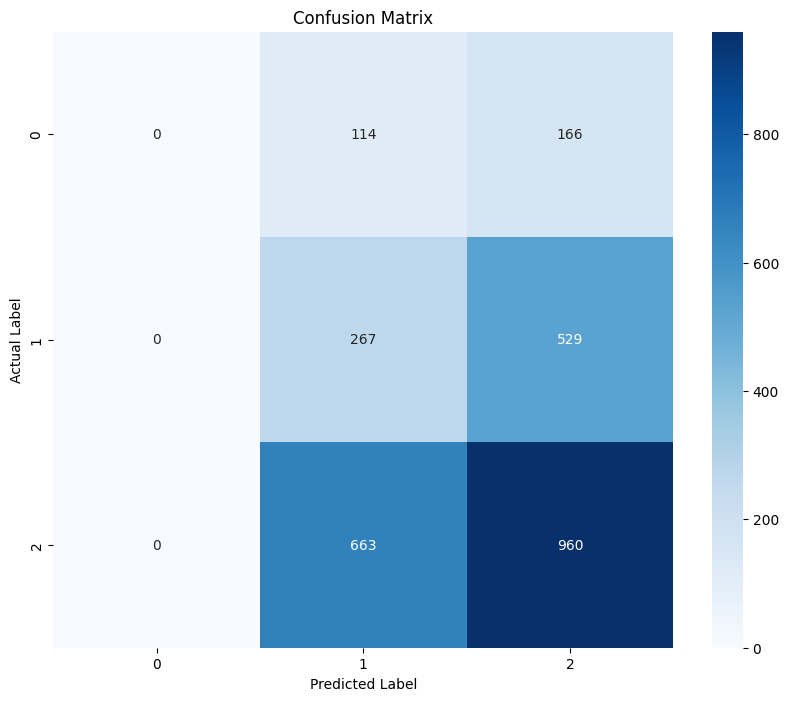

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(results_df['Actual Label'], results_df['Predicted Label'])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
results_df.to_csv("prediction_results.csv", index=False)

# 用 PPS 模型找出相關性高的特徵

In [44]:
import pandas as pd
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('dataB_change.csv')

selected_features = ['Group', 'Sex', 'Visit', 'Type', 'SITEID', 'DXCURREN','DXCHANGE', 'DXCONV', 'DXCONTYP', 'DXREV', 'DXNORM', 'DXNODEP', 'DXMCI', 'DXMDES', 'DXMPTR1', 'DXMPTR2', 'DXMPTR3', 'DXMPTR4', 'DXMPTR5', 'DXMPTR6', 'DXMDUE', 'DXMOTHET', 'DXDSEV', 'DXDDUE', 'DXAD', 'DXADES', 'DXAPP', 'DXAPROB', 'DXAPOSS', 'DXPARK', 'DXPDES', 'DXPCOG', 'DXPATYP', 'DXDEP', 'DXOTHDEM', 'DXODES', 'DXCONFID', 'DIAGNOSIS', 'update_stamp']
df_selected = df[selected_features]

In [50]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

label_encoder = LabelEncoder()

for col in ['Group', 'Sex']:
    df_selected[col] = label_encoder.fit_transform(df_selected[col].astype(str))

for col in df_selected.columns:
    if df_selected[col].dtype == float:
        df_selected[col] = df_selected[col].fillna(df_selected[col].median())

df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

   Group  Sex  Visit  Type  SITEID  DXCURREN  DXCHANGE  DXCONV  DXCONTYP  \
0      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
1      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
2      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
3      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
4      2    1    NaN   NaN      49       NaN         2     NaN       NaN   

   DXREV  ...  DXPARK  DXPDES  DXPCOG  DXPATYP  DXDEP  DXOTHDEM  DXODES  \
0    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
1    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
2    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
3    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
4    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   

   DXCONFID  DIAGNOSIS  update_stamp  
0       NaN        NaN           NaN  
1       NaN   

C:\Users\MR600\AppData\Local\Temp\ipykernel_18456\1808504101.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = label_encoder.fit_transform(df_selected[col].astype(str))
C:\Users\MR600\AppData\Local\Temp\ipykernel_18456\1808504101.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = label_encoder.fit_transform(df_selected[col].astype(str))
c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  retur

In [51]:
print(df_selected.head(5))

   Group  Sex  Visit  Type  SITEID  DXCURREN  DXCHANGE  DXCONV  DXCONTYP  \
0      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
1      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
2      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
3      2    1    NaN   NaN      49       NaN         2     NaN       NaN   
4      2    1    NaN   NaN      49       NaN         2     NaN       NaN   

   DXREV  ...  DXPARK  DXPDES  DXPCOG  DXPATYP  DXDEP  DXOTHDEM  DXODES  \
0    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
1    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
2    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
3    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   
4    NaN  ...       0     NaN     NaN      NaN    0.0       NaN     4.0   

   DXCONFID  DIAGNOSIS  update_stamp  
0       NaN        NaN           NaN  
1       NaN   

In [52]:
pps_matrix = pps.matrix(df_selected)

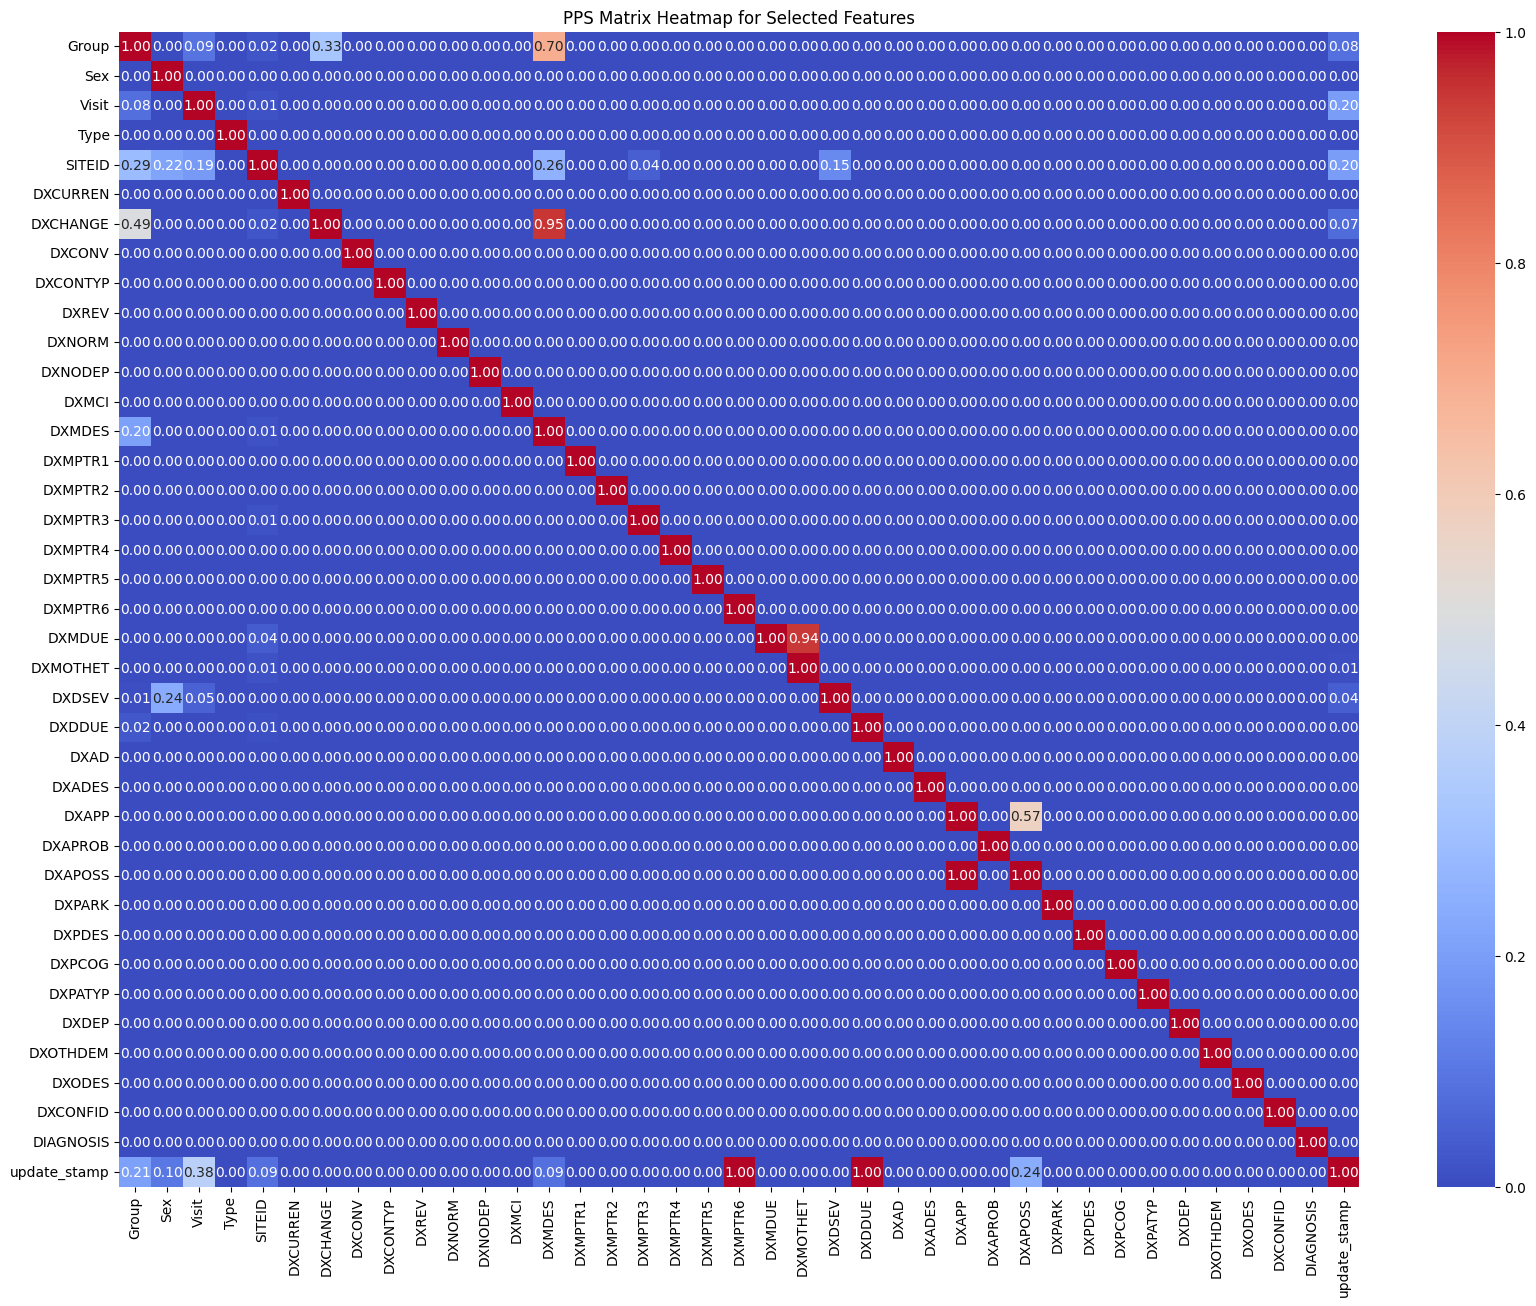

In [49]:
unique_x = pps_matrix['x'].unique()
unique_y = pps_matrix['y'].unique()

heatmap_df = pd.DataFrame(index=unique_x, columns=unique_y)

for row in pps_matrix.itertuples():
    heatmap_df.at[row.x, row.y] = row.ppscore

heatmap_df = heatmap_df.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("PPS Matrix Heatmap for Selected Features")
plt.show()

# 選擇用 ['Group', 'Sex', 'SITEID', 'DXMDES'] 當作訓練特徵與模型輸出向量一起訓練 SVM 模型

In [53]:
csv_path = 'dataB_change.csv'
df = pd.read_csv(csv_path)

labels = df['DXCHANGE']

In [54]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [55]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

for col in ['Group', 'Sex', 'SITEID', 'DXMDES']:
    transformed = label_encoder.fit_transform(df[col].astype(str))
    df[col] = transformed

df['Age'] = df['Age'].astype(float)

other_features = df[['DXMDES', 'Group', 'SITEID', 'Sex', 'Age']].values.astype(float)

In [56]:
print(other_features[:5])

[[ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]]


In [57]:
def predict_group(image_path, model):
    processed_image = process_mri_image(image_path)
    processed_image = torch.tensor(processed_image).unsqueeze(0)
    with torch.no_grad():  
        output = model(processed_image)
    return output.squeeze(0).numpy()

In [58]:
df['image_path'] = df['Image Data ID'].apply(lambda x: f'dataB/{x}.nii')
feature_vectors = [predict_group(path, model) for path in df['image_path']]

C:\Users\MR600\AppData\Local\Temp\ipykernel_18456\3497721540.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(processed_image).unsqueeze(0)


In [59]:
print(feature_vectors[:5])

[array([4.7642395e-08, 1.0000000e+00, 0.0000000e+00], dtype=float32), array([0., 1., 0.], dtype=float32), array([0.3663286 , 0.6229687 , 0.01070265], dtype=float32), array([2.388928e-17, 1.000000e+00, 0.000000e+00], dtype=float32), array([0., 1., 0.], dtype=float32)]


In [70]:
print(other_features[:5])

[[ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]
 [ 1.  2. 35.  1. 72.]]


# 只用 other_features 預測 DXCHANGE

In [68]:
X_train, X_test, y_train, y_test = train_test_split(other_features, labels, test_size=0.2, random_state=1)

from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.80


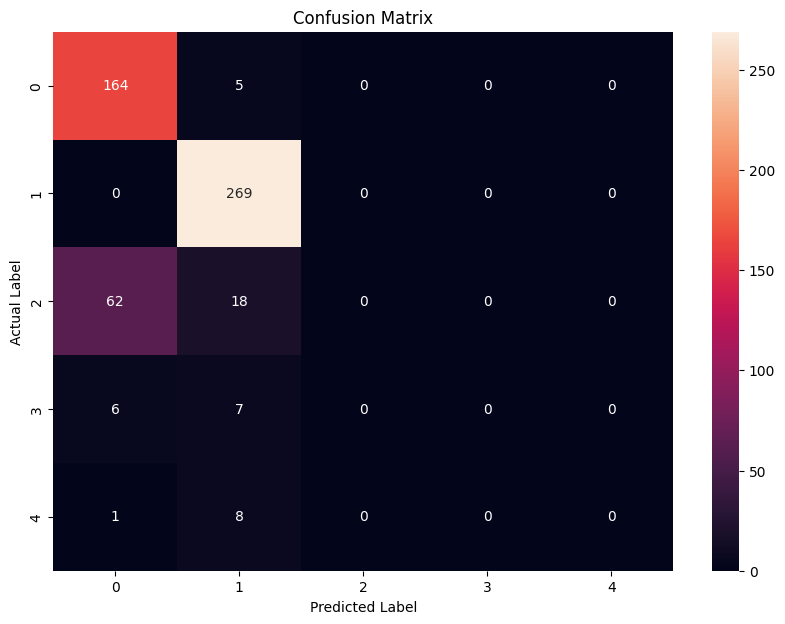

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.97      0.82       169
           2       0.88      1.00      0.93       269
           3       0.00      0.00      0.00        80
           5       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         9

    accuracy                           0.80       540
   macro avg       0.32      0.39      0.35       540
weighted avg       0.66      0.80      0.72       540

Accuracy: 0.80


c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 結合模型向量和 other_features 預測 DXCHANGE

In [66]:
combined_features = np.concatenate([feature_vectors, other_features], axis=1)

In [67]:
print(combined_features[:5])

[[4.76423949e-08 1.00000000e+00 0.00000000e+00 1.00000000e+00
  2.00000000e+00 3.50000000e+01 1.00000000e+00 7.20000000e+01]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
  2.00000000e+00 3.50000000e+01 1.00000000e+00 7.20000000e+01]
 [3.66328597e-01 6.22968674e-01 1.07026491e-02 1.00000000e+00
  2.00000000e+00 3.50000000e+01 1.00000000e+00 7.20000000e+01]
 [2.38892805e-17 1.00000000e+00 0.00000000e+00 1.00000000e+00
  2.00000000e+00 3.50000000e+01 1.00000000e+00 7.20000000e+01]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
  2.00000000e+00 3.50000000e+01 1.00000000e+00 7.20000000e+01]]


In [62]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=1)

from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.80


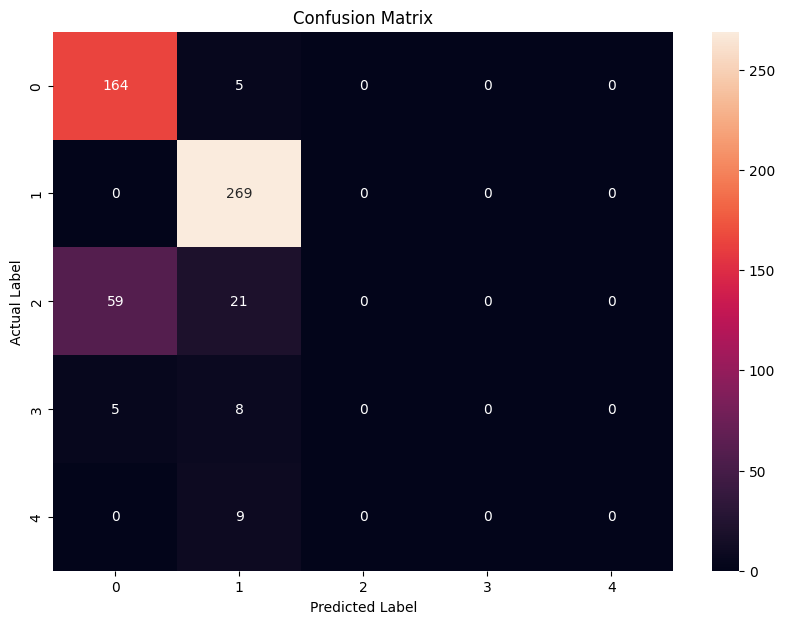

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.97      0.83       169
           2       0.86      1.00      0.93       269
           3       0.00      0.00      0.00        80
           5       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         9

    accuracy                           0.80       540
   macro avg       0.32      0.39      0.35       540
weighted avg       0.65      0.80      0.72       540

Accuracy: 0.80


c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
